## Questions:
- how many unique question askers are there? Is it just the same people again and again? Does this create a bias? (e.g. there are an awful lot of questions on bees)
- there are lots of funny questions - what percentage of total? Maybe this shows people prefer the less-serious questions? Or are just science room people particularly comedic?
- look at percentage of questions on apocalypse, health, technology - seems people are particularly concered with mortality 
- very few engineering or chemistry questions?
- most physics questions are space or sound
- lots of food / nutrition questions 
- SO MUCH PSYCHOLOGY (is this a Jamal bias though?)


In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [71]:
def dateparse(x):
    if x == 'Pilot':
        x = '14/06/2017'
    return pd.datetime.strptime(x, '%d/%m/%Y')
#dateparse = lambda x: pd.datetime.strptime(x, '%d/%m/%Y')

funnyparse = lambda x: False if x == 'n' else True

qs = pd.read_csv('sciroom_tagged.csv', skiprows=2, parse_dates=['When?'], date_parser=dateparse,
                 converters={'Funny':funnyparse, 'human':funnyparse})

In [72]:
qs.rename(columns={'When?':'date', 'Will this be a potential talk, blog post, or nothing? ':'output_type', 
                   'Who?':'who', 'Other comments':'comments', 'Name': 'first_name', 'Questions':'questions'}, inplace=True)

In [73]:
#qs['last_name'] = None
qs.insert(1, 'last_name', None)
for i, r in qs.iterrows():
    if r.last_name is None:
        try:
            names = r['first_name'].split(' ')
            if len(names) > 1:
                qs.set_value(i, 'first_name', names[0])
                qs.set_value(i, 'last_name', ' '.join(names[1:]))
        except AttributeError:
            pass


In [104]:
#qs["date"] = qs["date"].astype("datetime64")
#qs[['first_name', 'date', 'questions']].head(10)
qs.drop(['last_name', 'comments', 'who'], axis=1).head(10)

,first_name,date,questions,output_type,Funny,human,Tags,genre
0,Przemek,2015-06-01,"""Could machines be conscious?""",Event,False,False,"technology, engineering, consciousness",psychology
1,Przemek,2015-06-01,"""Are we approaching to an ecological collapse?""",Event,False,False,"biology, apocalypse, ecology",biology
2,Philip,2015-06-01,"""Are we losing the war on disease?""",Event,False,True,"disease, apocalypse, medicine, biology",biology
3,Philip,2015-06-01,"""Is the nature of reality dependent on our obs...",Content: Read,False,True,"psychology, philosophy, reality",biology
4,Tim,2015-06-01,"""What inventions would we not have without the...",Event / Content,False,True,"engineering, space, technology",physics
5,Tim,2015-06-01,"""What inventions would we not have without war...",Event / Content,False,True,"anthropology, history, technology, engineering",None
6,Tim,2015-06-01,"""How can science / technology make us happier?""",Event / Podcast,False,True,"technology, anthropology, neuroscience, psycho...",psychology
7,Andrei,2015-06-01,"""What would the world be like without or with ...",Event / Content,False,False,"gravity, physics",physics
8,Abhi,2015-07-04,"""How do mirror neurons work?""",Content,False,True,"biology, neuroscience",biology
9,Reshma,2015-07-04,"""Can a machine identify cancer cell developing...",Event,False,True,"cancer, technology, medicine, biology",biology


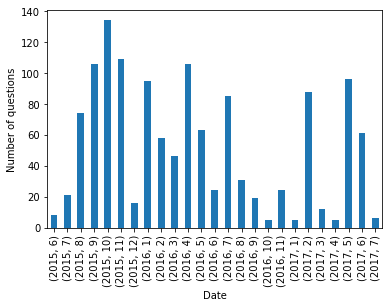

In [75]:
fig = qs[['date']].groupby([qs["date"].dt.year, qs["date"].dt.month]).count().plot(kind="bar", legend=False)
fig.set_xlabel('Date')
fig.set_ylabel('Number of questions')
plt.show()

In [76]:
# Note: to avoid selection bias, I'm going to need to classify a reasonable fraction of questions. 
# Otherwise e.g. I could just be counting the physics questions.

biology_words = ["ecological", "disease", "nature", "plants", "animals", "animal", "biology", "biological", 
                 "neurons", "cancer", "cell", "diet", "evolution", "human", "life", "zombie", "DNA",
                "species", "drunk", "nutrition", "virus", "drug", "exercise", "blood", "elephant", "bee", "cat"]
physics_words = ["space", "black hole", "star", "universe", "quantum", "physics", "radiation", "light", "moon",
                "mars", "wormhole", "turbulence", "time", "particles", "antimatter", "nuclear", "clock",
                "wavefunction", "electricity", "power", "gravity", "planet", "dimension", "gravitation", "telescope",
                "magnet", "vibrat", "big bang"]
chemistry_words = ["chemicals", "chemical", "metal", "chemistry", "material", "mineral", "fracking"]
psychology_words = ["psychology", "brain", "conscious", "mind", "memory", "memories"]

In [77]:
qs['genre'] = None

for i, r in qs.iterrows():
    # first try looking at the comments 
    
    try:
        comments = r['comments'].lower()
    except AttributeError:
        comments = ''
        
    if "biolog" in comments:
        qs.set_value(i, 'genre', 'biology')
    elif "physics" in comments:
            qs.set_value(i, 'genre', 'physics')
    elif "chemist" in comments:
        qs.set_value(i, 'genre', 'chemistry')
    elif "psycholog" in comments:
        qs.set_value(i, 'genre', 'psychology')    
    else: 
        for w in biology_words:
            if w in r['questions'].lower() + ' ' + comments:
                qs.set_value(i, 'genre', 'biology')
                break
        for w in physics_words:
            if w in r['questions'].lower() + ' ' + comments:
                qs.set_value(i, 'genre', 'physics')
                break
        for w in chemistry_words:
            if w in r['questions'].lower() + ' ' + comments:
                qs.set_value(i, 'genre', 'chemistry')
                break
        for w in psychology_words:
            if w in r['questions'].lower() + ' ' + comments:
                qs.set_value(i, 'genre', 'psychology')
                break

## Looking at tags and human / funny

In [108]:
def tag_me(df):
    apocalypse = 0
    psychology = 0
    health = 0
    food = 0

    tag = pd.DataFrame(columns=['freq', 'funny', 'human'])

    for i, r in df.iterrows():
        try:
            if 'apocalypse' in r.Tags:
                apocalypse += 1
            if 'psychology' in r.Tags:
                psychology += 1
            if 'health' in r.Tags:
                health += 1
            if 'food' in r.Tags:
                food += 1

            ts = r.Tags.split(', ')
            for w in ts:
                if w[-1] == ' ':
                    w = w[:-1]
                try:
                    tag.set_value(w, 'freq', tag.loc[w]['freq'] + 1)
                except KeyError:
                    tag.loc[w] = 0
                    tag.set_value(w, 'freq', 1)
                if r.Funny:
                    tag.set_value(w, 'funny', tag.loc[w]['funny'] + 1)
                if r.human:
                    tag.set_value(w, 'human', tag.loc[w]['human'] + 1)
        except TypeError:
            pass

    print(apocalypse/len(df), psychology/len(df), health/len(df), food/len(df))
    tag.sort_values('freq', ascending=False, inplace=True)
    for i, r in tag.iterrows():
        tag.set_value(i, 'funny', r.funny / r.freq)
        tag.set_value(i, 'human', r.human / r.freq)
    return tag

tags = tag_me(qs)

0.028527370855821126 0.28218966846569005 0.11873554356206631 0.07710100231303008


In [79]:
psychology / len(qs)

0.28218966846569005

In [80]:
sum(qs.Funny) / len(qs)

0.2336160370084811

In [81]:
sum(qs.human) / len(qs)

0.76175790285273703

In [109]:
tags.head(10)

,freq,funny,human
biology,447,0.270694,0.778523
psychology,366,0.155738,0.937158
physics,239,0.284519,0.401674
technology,197,0.228426,0.913706
health,154,0.0909091,0.993506
ecology,104,0.432692,0.346154
food,100,0.29,0.9
space,91,0.175824,0.428571
neuroscience,84,0.0952381,0.988095
philosophy,83,0.39759,0.843373


In [14]:
import plotly
plotly.offline.init_notebook_mode(connected=True)
import plotly.plotly as py
import plotly.graph_objs as go
import plotly.tools as tls

In [15]:
msize = lambda x: np.sqrt(np.float(x))

fig = tls.make_subplots(rows=1, cols=1)
x = tags.human
y = tags.funny
text = [i + ': ' + str(tags.loc[i]['freq']) for i in tags.index.values]
t = go.Scatter(x=x, y=y, mode='markers', text=text, 
               marker=dict(size=[3*x**0.5 for x in tags.freq], 
                          color=[3*x**0.5 for x in tags.freq],
                          colorscale='Viridis'))
fig.append_trace(t, 1, 1)

fig['layout']['xaxis1'].update(title='Human')
fig['layout']['yaxis1'].update(title='Funny')
fig['layout'].update(hovermode='closest')
plotly.offline.iplot(fig)

This is the format of your plot grid:
[ (1,1) x1,y1 ]



## Finding common question words

In [16]:
qword = dict()
for i, r in qs.iterrows():
    w = r.questions.split(' ')[0][1:].split("'")[0].split(",")[0].lower()
    qword.setdefault(w, 0)
    qword[w] += 1

In [17]:
for k in sorted(qword, key=qword.get, reverse=True):
    if qword[k] < 3:
        break
    print(k, qword[k])

how 236
what 224
why 198
is 134
are 63
can 58
does 52
do 50
could 43
if 30
will 28
when 27
where 18
should 15
would 13
which 10
to 10
in 5
who 5
has 4
at 4
did 3
the 3


## Finding unique questioners 

In [102]:
questers = qs[['first_name', 'last_name']].drop_duplicates()
questers.drop('last_name', axis=1).head()

,first_name
0,Przemek
2,Philip
4,Tim
7,Andrei
8,Abhi


In [33]:
len(qs) / len(questers)

3.3864229765013056

This demonstrates we indeed have quite a few repeat questioners. Let's look at the most curious:

In [35]:
questers['freq'] = 0
for i, r in questers.iterrows():
    questers.set_value(i, 'freq', len(qs.loc[(qs.first_name == r.first_name) & (qs.last_name == r.last_name)]))

In [101]:
questers.sort_values('freq', ascending=False, inplace=True)
questers.drop('last_name', 'comments', 'who', axis=1).head(10)

,first_name,freq
133,Jamal,84
502,Matt,46
520,Sean,36
125,Olly,33
142,John,25
2,Philip,25
69,Tom,23
371,Matt,21
4,Tim,20
53,Simon,17


In [41]:
questers['freq'].describe()

count    383.000000
mean       2.694517
std        6.487454
min        0.000000
25%        0.000000
50%        1.000000
75%        2.000000
max       84.000000
Name: freq, dtype: float64

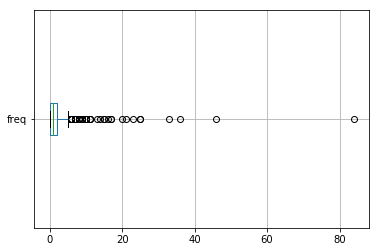

In [44]:
questers.boxplot('freq', vert=False)
plt.show()

Looking at that box plot, we see that indeed our dataset is dominated by contributions from just a few people. Let's see what percentage of the total questions are asked by the top 10 askers:

In [49]:
np.sum(questers.freq.head(10).values) / len(qs)

0.25443330763299921

That's over 25% of the questions which have been asked by just 10 people! This is likely to seriously bias our dataset, as these people are likely to ask questions on similar topics (e.g. Jamal tends to ask about psychology), making our dataset less representative of the general population. To tackle this, let's limit each person to the mean number of questions, rounded up (3). We'll select these randomly from their total questions, and run some analysis again a few times with different random selections to see if we get the same results. 

In [95]:
from random import sample
qs_unbiased = pd.DataFrame(columns=qs.columns)
for i, r in questers.iterrows():
    rs = qs.loc[(qs.first_name == r.first_name) & (qs.last_name == r.last_name)]
    if len(rs) > 3:
        s = sample(range(len(rs)), 3)
        rs = rs.iloc[s]
    qs_unbiased = qs_unbiased.append(rs)

In [105]:
qs_unbiased.drop(['last_name', 'comments', 'who'], axis=1).head(10)

,first_name,date,questions,output_type,Funny,human,Tags,genre
275,Jamal,2015-10-20,"""Can we ever make a computer program that perp...",NaN,False,True,"AI, computer science",None
278,Jamal,2015-10-21,"""To what extent should we treat people with me...",NaN,False,True,"health, ethics, psychology",None
347,Jamal,2015-11-08,"""Will it ever be possible to gain infinite sta...",NaN,False,True,"biology, health, medicine",None
708,Matt,2016-04-10,"""How big have pre-historic bees ever got?""",NaN,False,False,"biology, ecology",biology
706,Matt,2016-04-10,"""Just how important are bees compared to other...",NaN,False,False,"biology, ecology",biology
959,Matt,2016-08-27,"""How much does the body heat up due to physica...",NaN,False,True,"biology, anatomy",None
1054,Sean,2017-02-22,"""What's the best drug?""",NaN,False,True,"medicine, biology, health",biology
750,Sean,2016-04-10,"""What if I raised 20 babies in a completely wh...",NaN,False,True,psychology,None
900,Sean,2016-07-26,"""Are there Lesser Danes? Do they feel bad abou...",NaN,True,False,"ecology, psychology",None
497,Olly,2016-01-04,"""How does modern lego affect post-war preconst...",NaN,True,True,"engineering, technology",None


In [97]:
len(qs_unbiased)

479

In [111]:
tags_u = tag_me(qs_unbiased)

0.020876826722338204 0.2776617954070981 0.12108559498956159 0.06889352818371608


In [112]:
tags_u.head(10)

,freq,funny,human
biology,164,0.317073,0.780488
psychology,133,0.142857,0.932331
physics,97,0.329897,0.463918
technology,78,0.24359,0.935897
health,58,0.0862069,1
ecology,41,0.463415,0.292683
space,37,0.189189,0.540541
food,33,0.272727,0.878788
engineering,30,0.266667,0.733333
medicine,30,0.166667,0.933333


In [113]:
tags.head(10)

,freq,funny,human
biology,447,0.270694,0.778523
psychology,366,0.155738,0.937158
physics,239,0.284519,0.401674
technology,197,0.228426,0.913706
health,154,0.0909091,0.993506
ecology,104,0.432692,0.346154
food,100,0.29,0.9
space,91,0.175824,0.428571
neuroscience,84,0.0952381,0.988095
philosophy,83,0.39759,0.843373


In [114]:
tags_u.freq.head(10).values / len(qs_unbiased)

array([0.34237995824634654, 0.2776617954070981, 0.20250521920668058,
       0.162839248434238, 0.12108559498956159, 0.08559498956158663,
       0.07724425887265135, 0.06889352818371608, 0.06263048016701461,
       0.06263048016701461], dtype=object)

In [115]:
tags.freq.head(10).values / len(qs)

array([0.3446414803392444, 0.28218966846569005, 0.18427139552814187,
       0.15188897455666925, 0.11873554356206631, 0.08018504240555127,
       0.07710100231303008, 0.07016191210485737, 0.06476484194294525,
       0.06399383191981496], dtype=object)

This is actually pretty encouraging: the top 10 most popular tags are more or less the same, as are the percentages with which they occur and their funnyness / humanity. This suggests that although our dataset may be dominated by the contributions from a relatively small number of people, their contributions are largely representative of the total population and do not appear to bias the results significantly. We can therefore continue our analysis with the complete dataset. 